In [1]:
from pathlib import Path

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

In [3]:
DATA_FOLDER = (Path.cwd() / "../data/copernicus/monthly/2m-temperature/").resolve()

In [4]:
file_list = list(DATA_FOLDER.glob("*.tsv.zip"))
for f in file_list[:5]:
    print(f.stem)

era5_2m_temperature_1940_monthly_ensemble.tsv
era5_2m_temperature_1941_monthly_ensemble.tsv
era5_2m_temperature_1942_monthly_ensemble.tsv
era5_2m_temperature_1943_monthly_ensemble.tsv
era5_2m_temperature_1944_monthly_ensemble.tsv


In [52]:
MONTH_LEN = {
        1: 31,
        2: 28,
        3: 31,
        4: 30,
        5: 31,
        6: 30,
        7: 31,
        8: 31,
        9: 30,
        10: 31,
        11: 30,
        12: 31
    }

def get_month_len(v):
    res = MONTH_LEN[v]
    return res

years_lst = list()
glob_avgs_lst = list()
patt = r"\d{4}"

for data_file in file_list:
    df = pd.read_csv(
        str(data_file.resolve()),
        index_col=["longitude", "latitude", "time"], 
        sep="\t",
        parse_dates=["time"],
    )
    df["abs_lat"] = np.abs(df.index.get_level_values(level="latitude"))
    df = df[df.abs_lat <= 80]
    df["year"] = df.index.get_level_values(level="time").year    
    df["month"] = df.index.get_level_values(level="time").month
    df["month_len"] = df["month"].apply(get_month_len)
    df["weight_t"] = df["t2m"] * df["month_len"]
    df = df.reset_index()
    grouped = df.groupby(["longitude", "latitude", "year"])
    summed = grouped[["weight_t", "month_len"]].sum()
    summed["avg_temp"] = summed["weight_t"] / summed["month_len"]
    #print(summed.head())
    summed["k_f"] = \
        np.cos(
            np.radians(
                np.abs(summed.index.get_level_values("latitude"))
            )
        ) ** 2
    summed["k_fd_avg_t"] = summed["avg_temp"] * summed["k_f"]
    #df = df.groupby(level=["longitude", "latitude"])
    #df["k"] = np.cos(np.radians(df["abs_lat"].values)) ** 2
    #df["wt_t_k_adj"] = df["weight_t"] * df["k"]
    #k_sum = df["k"].sum()
    #df["comp_weight"] = df["wt_t_k_adj"] / k_sum
    year = int(re.findall(patt, data_file.stem)[0])
    glob_avg = summed["k_fd_avg_t"].sum() / summed["k_f"].sum()
    years_lst.append(year)
    glob_avgs_lst.append(glob_avg)
    print(f"year: {year} global average {glob_avg}")
    #glob_avg = df.weight_t.sum() / 365
    #print(glob_avg.head(100))
    

year: 1940 global average 17.544237755495054
year: 1941 global average 17.60758250602801
year: 1942 global average 17.49059367645222
year: 1943 global average 17.426036089993197
year: 1944 global average 17.62314688309057
year: 1945 global average 17.502711482436705
year: 1946 global average 17.561346913834583
year: 1947 global average 17.57033213832652
year: 1948 global average 17.583103465893437
year: 1949 global average 17.554115128364224
year: 1950 global average 17.46261585247634
year: 1951 global average 17.639075281793037
year: 1952 global average 17.634903579867274
year: 1953 global average 17.685879409428264
year: 1954 global average 17.505984029098666
year: 1955 global average 17.46336838859202
year: 1956 global average 17.402244911148657
year: 1957 global average 17.673660889923084
year: 1958 global average 17.786630693765183
year: 1959 global average 17.672894652706333
year: 1960 global average 17.648328396328857
year: 1961 global average 17.712122396830278
year: 1962 globa

In [54]:
glob_df = pd.DataFrame({"glob_avg": glob_avgs_lst, }, index=years_lst)
glob_df.head()

,glob_avg
1940,17.544238
1941,17.607583
1942,17.490594
1943,17.426036
1944,17.623147


In [59]:
glob_df["roll_avg_7"] = glob_df["glob_avg"].rolling(window=7).mean()
glob_df.tail(10)

,glob_avg,roll_avg_7
2015,18.489374,18.286023
2016,18.604287,18.335862
2017,18.508704,18.361428
2018,18.420412,18.403149
2019,18.562092,18.452399
2020,18.568902,18.495205
2021,18.463920,18.516813
2022,18.432505,18.508689
2023,18.769568,18.532300
2024,18.724521,18.563131


<Axes: >

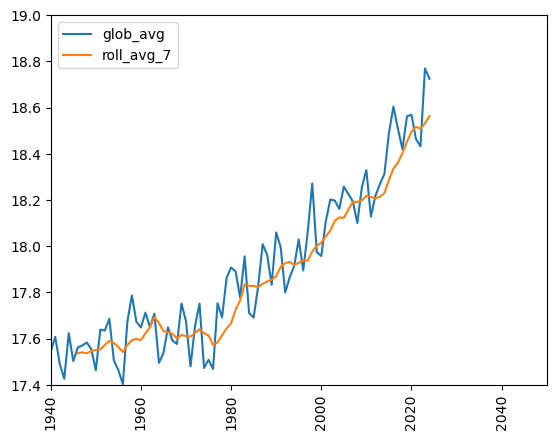

In [70]:
glob_df.plot(y=["glob_avg", "roll_avg_7"], rot=90, xlim=(1940, 2050), ylim=(17.4, 19.0))

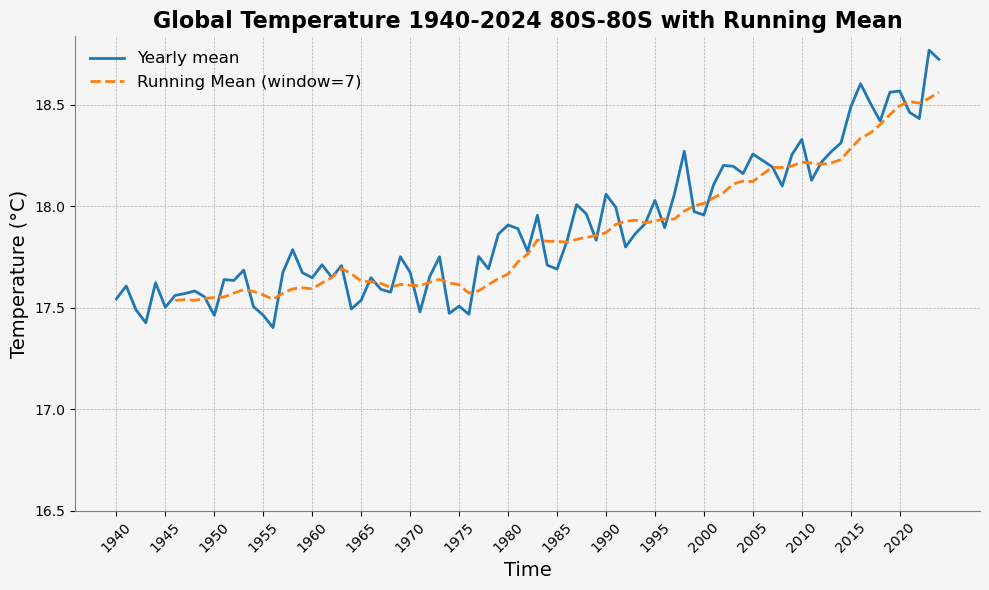

In [86]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data
ax.plot(glob_df.index, glob_df["glob_avg"], label="Yearly mean", color='tab:blue', linewidth=2)
ax.plot(glob_df.index, glob_df["roll_avg_7"], label='Running Mean (window=7)', linestyle='--', color='tab:orange', linewidth=2)

# Customize ticks
ax.set_xticks(np.arange(1940, 2025, 5))
ax.set_xticklabels(np.arange(1940, 2025, 5), rotation=45)
ax.set_yticks(np.arange(int(glob_df['glob_avg'].min()) - 0.5, int(glob_df['glob_avg'].max()) + 1.0, 0.5))

# Add grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customize spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')

# Customize the background
ax.set_facecolor('#f5f5f5')
fig.patch.set_facecolor('#f5f5f5')

# Set title and labels
ax.set_title('Global Temperature 1940-2024 80S-80S with Running Mean', fontsize=16, weight='bold')
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Temperature (°C)', fontsize=14)

# Customize the legend
ax.legend(frameon=False, fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

In [90]:
fig_folder = (Path.cwd() / "../../fig_output/")
fig_folder.mkdir(exist_ok=True)
print(str(fig_folder.resolve()))

C:\Dropbox\CODE2\data-analysis\github\graphs-for-sm\fig_output


In [91]:
fig.savefig((fig_folder / "global_average_1940-2024_80s-90n.png").resolve()) 